In [1]:
import sys
sys.path.append("../")

from torch import nn
from data_utils import load_mnist, load_usps
from models import DomainAdaptationNetwork

import torch
from torch.nn import functional as F
import numpy as np
from train import train_domain_adaptation
from utils import test_network, plot_target_cross_domain_swapping, plot_tsne

In [2]:
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_space_dim, conv_feat_size, nb_channels=3):
        super(Decoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.conv_feat_size = conv_feat_size

        self.deco_dense = nn.Sequential(
            nn.Linear(in_features=latent_space_dim, out_features=1024),
            nn.ReLU(True),
            nn.Linear(in_features=1024, out_features=np.prod(self.conv_feat_size)),
            nn.ReLU(True),
        )

        self.deco_fetures = nn.Sequential(
            nn.Conv2d(in_channels=self.conv_feat_size[0], out_channels=75, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=75, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=50, out_channels=1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

    def forward(self, z_share, z_spe):
        z = torch.cat([z_share, z_spe], 1)
        feat_encode = self.deco_dense(z)
        feat_encode = feat_encode.view(-1, *self.conv_feat_size)
        y = self.deco_fetures(feat_encode)

        return y


class Encoder(nn.Module):
    def __init__(self, latent_space_dim, img_size, nb_channels=3):
        super(Encoder, self).__init__()

        self.latent_space_dim = latent_space_dim
        self.nb_channels = nb_channels

        self.conv_feat = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=50, out_channels=75, kernel_size=5, padding=2),
            nn.ReLU(True),
            nn.BatchNorm2d(75),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=75, out_channels=100, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(100),
        )

        self.conv_feat_size = self.conv_feat(torch.zeros(1, *img_size)).shape[1:]
        self.dense_feature_size = np.prod(self.conv_feat_size)

        self.dense_feat = nn.Sequential(
            nn.Linear(in_features=self.dense_feature_size, out_features=1024),
            nn.ReLU(True), )

        self.share_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.source_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

        self.target_feat = nn.Sequential(
            nn.Linear(in_features=1024, out_features=latent_space_dim),
            nn.ReLU(True),
        )

    def forward(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        z_source = self.source_feat(feat)
        z_target = self.target_feat(feat)
        return z_share, z_source, z_target

    def forward_share(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_share = self.share_feat(feat)
        return z_share

    def forward_source(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_source = self.source_feat(feat)
        return z_source

    def forward_target(self, input_data):
        if (input_data.shape[1] == 1) & (self.nb_channels == 3):
            input_data = input_data.repeat(1, 3, 1, 1)
        feat = self.conv_feat(input_data)
        feat = feat.view(-1, self.dense_feature_size)
        feat = self.dense_feat(feat)
        z_target = self.target_feat(feat)
        return z_target


In [4]:
learning_rate = 5e-4

source_train_loader, source_test_loader = load_mnist(img_size=32, rotation=20, batch_size=128, shuffle=True, num_workers=2) 
target_train_loader, _ = load_usps(img_size=32, rotation=20, split=1, batch_size=128, shuffle=True, num_workers=2)

encoder = Encoder(latent_space_dim=150, img_size=(1,32,32), nb_channels=1)

conv_feat_size = encoder.conv_feat_size
decoder_source = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)
decoder_target = Decoder(latent_space_dim=300, conv_feat_size=conv_feat_size, nb_channels=1)

classifier = nn.Sequential(nn.Dropout2d(0.3),
                         nn.Linear(in_features=150, out_features=64),
                         nn.ReLU(0),
                         nn.Dropout2d(0.2),
                         nn.Linear(in_features=64, out_features=10),
                         nn.LogSoftmax())

model = DomainAdaptationNetwork(encoder, decoder_source, decoder_target, classifier).cuda()

optimizer = torch.optim.Adam([
    {'params': model.encoder.parameters()},
    {'params': model.decoder_source.parameters()},
    {'params': model.decoder_target.parameters()},
    {'params': model.classifier.parameters()},
    {'params': model.spe_predictor.parameters()},
    {'params': model.share_predictor.parameters()}], lr=learning_rate, weight_decay=0.001)

epochs = 50
betas = np.linspace(0, 5, epochs)

train_domain_adaptation(model, optimizer, source_train_loader, target_train_loader,
                                            epochs=50, betas=betas, gamma=0.5, delta=0.5)

  0%|          | 0/50 [00:00<?, ?it/s]/home/david/anaconda3/envs/domain_adaptation/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
epoch:0 current target accuracy:54.26%:   2%|▏         | 1/50 [00:08<06:39,  8.15s/it]

epoch [1/50], loss:0.2921
accuracy source: 77.34%
accuracy target: 54.31%


epoch:1 current target accuracy:80.99%:   4%|▍         | 2/50 [00:16<06:27,  8.08s/it]

epoch [2/50], loss:0.1631
accuracy source: 95.05%
accuracy target: 81.06%


epoch:2 current target accuracy:87.46%:   6%|▌         | 3/50 [00:24<06:18,  8.06s/it]

epoch [3/50], loss:0.1382
accuracy source: 96.45%
accuracy target: 87.53%


epoch:3 current target accuracy:89.84%:   8%|▊         | 4/50 [00:32<06:14,  8.13s/it]

epoch [4/50], loss:0.1284
accuracy source: 97.22%
accuracy target: 89.92%


epoch:4 current target accuracy:91.63%:  10%|█         | 5/50 [00:40<06:05,  8.13s/it]

epoch [5/50], loss:0.1215
accuracy source: 97.97%
accuracy target: 91.7%


epoch:5 current target accuracy:91.83%:  12%|█▏        | 6/50 [00:48<05:56,  8.11s/it]

epoch [6/50], loss:0.1199
accuracy source: 97.89%
accuracy target: 91.91%


epoch:6 current target accuracy:92.38%:  14%|█▍        | 7/50 [00:56<05:47,  8.08s/it]

epoch [7/50], loss:0.1150
accuracy source: 98.16%
accuracy target: 92.46%


epoch:7 current target accuracy:92.42%:  16%|█▌        | 8/50 [01:04<05:38,  8.06s/it]

epoch [8/50], loss:0.1124
accuracy source: 98.4%
accuracy target: 92.5%


epoch:8 current target accuracy:91.68%:  18%|█▊        | 9/50 [01:12<05:31,  8.08s/it]

epoch [9/50], loss:0.1089
accuracy source: 98.37%
accuracy target: 91.76%


epoch:9 current target accuracy:92.87%:  20%|██        | 10/50 [01:20<05:23,  8.08s/it]

epoch [10/50], loss:0.1098
accuracy source: 98.31%
accuracy target: 92.95%


epoch:10 current target accuracy:92.01%:  22%|██▏       | 11/50 [01:28<05:15,  8.08s/it]

epoch [11/50], loss:0.1076
accuracy source: 98.19%
accuracy target: 92.09%


epoch:11 current target accuracy:93.04%:  24%|██▍       | 12/50 [01:36<05:07,  8.08s/it]

epoch [12/50], loss:0.1061
accuracy source: 98.41%
accuracy target: 93.11%


epoch:12 current target accuracy:94.13%:  26%|██▌       | 13/50 [01:45<04:59,  8.09s/it]

epoch [13/50], loss:0.1018
accuracy source: 98.7%
accuracy target: 94.21%


epoch:13 current target accuracy:95.34%:  28%|██▊       | 14/50 [01:53<04:51,  8.11s/it]

epoch [14/50], loss:0.1012
accuracy source: 98.27%
accuracy target: 95.42%


epoch:14 current target accuracy:94.27%:  30%|███       | 15/50 [02:01<04:44,  8.12s/it]

epoch [15/50], loss:0.1013
accuracy source: 98.56%
accuracy target: 94.35%


epoch:15 current target accuracy:93.74%:  32%|███▏      | 16/50 [02:09<04:36,  8.13s/it]

epoch [16/50], loss:0.1039
accuracy source: 98.0%
accuracy target: 93.81%


epoch:16 current target accuracy:93.74%:  34%|███▍      | 17/50 [02:17<04:28,  8.14s/it]

epoch [17/50], loss:0.1027
accuracy source: 98.29%
accuracy target: 93.81%


epoch:17 current target accuracy:94.5%:  36%|███▌      | 18/50 [02:25<04:22,  8.19s/it] 

epoch [18/50], loss:0.0990
accuracy source: 98.45%
accuracy target: 94.58%


epoch:18 current target accuracy:95.29%:  38%|███▊      | 19/50 [02:34<04:13,  8.18s/it]

epoch [19/50], loss:0.0957
accuracy source: 98.73%
accuracy target: 95.36%


epoch:19 current target accuracy:94.33%:  40%|████      | 20/50 [02:42<04:04,  8.14s/it]

epoch [20/50], loss:0.0933
accuracy source: 98.83%
accuracy target: 94.4%


epoch:20 current target accuracy:94.38%:  42%|████▏     | 21/50 [02:50<03:57,  8.18s/it]

epoch [21/50], loss:0.0967
accuracy source: 98.52%
accuracy target: 94.46%


epoch:21 current target accuracy:94.76%:  44%|████▍     | 22/50 [02:58<03:48,  8.17s/it]

epoch [22/50], loss:0.0938
accuracy source: 98.68%
accuracy target: 94.84%


epoch:22 current target accuracy:95.0%:  46%|████▌     | 23/50 [03:06<03:40,  8.16s/it] 

epoch [23/50], loss:0.0919
accuracy source: 98.63%
accuracy target: 95.08%


epoch:23 current target accuracy:95.68%:  48%|████▊     | 24/50 [03:14<03:31,  8.14s/it]

epoch [24/50], loss:0.0913
accuracy source: 98.79%
accuracy target: 95.76%


epoch:24 current target accuracy:95.45%:  50%|█████     | 25/50 [03:23<03:23,  8.14s/it]

epoch [25/50], loss:0.0927
accuracy source: 98.75%
accuracy target: 95.53%


epoch:25 current target accuracy:95.48%:  52%|█████▏    | 26/50 [03:31<03:16,  8.21s/it]

epoch [26/50], loss:0.0892
accuracy source: 98.89%
accuracy target: 95.56%


epoch:26 current target accuracy:95.81%:  54%|█████▍    | 27/50 [03:39<03:09,  8.25s/it]

epoch [27/50], loss:0.0886
accuracy source: 98.83%
accuracy target: 95.88%


epoch:27 current target accuracy:95.15%:  56%|█████▌    | 28/50 [03:47<03:00,  8.20s/it]

epoch [28/50], loss:0.0912
accuracy source: 98.59%
accuracy target: 95.23%


epoch:28 current target accuracy:95.61%:  58%|█████▊    | 29/50 [03:55<02:52,  8.20s/it]

epoch [29/50], loss:0.0903
accuracy source: 98.7%
accuracy target: 95.69%


epoch:29 current target accuracy:96.01%:  60%|██████    | 30/50 [04:04<02:43,  8.18s/it]

epoch [30/50], loss:0.0879
accuracy source: 98.93%
accuracy target: 96.09%


epoch:30 current target accuracy:95.57%:  62%|██████▏   | 31/50 [04:12<02:37,  8.27s/it]

epoch [31/50], loss:0.0891
accuracy source: 98.85%
accuracy target: 95.65%


epoch:31 current target accuracy:95.38%:  64%|██████▍   | 32/50 [04:20<02:28,  8.23s/it]

epoch [32/50], loss:0.0899
accuracy source: 98.75%
accuracy target: 95.46%


epoch:32 current target accuracy:95.23%:  66%|██████▌   | 33/50 [04:29<02:21,  8.32s/it]

epoch [33/50], loss:0.0886
accuracy source: 98.86%
accuracy target: 95.31%


epoch:33 current target accuracy:96.16%:  68%|██████▊   | 34/50 [04:37<02:12,  8.31s/it]

epoch [34/50], loss:0.0858
accuracy source: 99.03%
accuracy target: 96.24%


epoch:34 current target accuracy:96.11%:  70%|███████   | 35/50 [04:45<02:04,  8.27s/it]

epoch [35/50], loss:0.0853
accuracy source: 99.23%
accuracy target: 96.19%


epoch:35 current target accuracy:95.85%:  72%|███████▏  | 36/50 [04:54<01:56,  8.34s/it]

epoch [36/50], loss:0.0867
accuracy source: 98.92%
accuracy target: 95.93%


epoch:36 current target accuracy:95.72%:  74%|███████▍  | 37/50 [05:02<01:47,  8.25s/it]

epoch [37/50], loss:0.0870
accuracy source: 98.97%
accuracy target: 95.8%


epoch:37 current target accuracy:96.16%:  76%|███████▌  | 38/50 [05:10<01:40,  8.34s/it]

epoch [38/50], loss:0.0849
accuracy source: 99.12%
accuracy target: 96.24%


epoch:38 current target accuracy:95.82%:  78%|███████▊  | 39/50 [05:19<01:31,  8.31s/it]

epoch [39/50], loss:0.0872
accuracy source: 98.73%
accuracy target: 95.9%


epoch:39 current target accuracy:96.31%:  80%|████████  | 40/50 [05:27<01:23,  8.36s/it]

epoch [40/50], loss:0.0816
accuracy source: 99.22%
accuracy target: 96.39%


epoch:40 current target accuracy:96.41%:  82%|████████▏ | 41/50 [05:35<01:15,  8.37s/it]

epoch [41/50], loss:0.0840
accuracy source: 98.99%
accuracy target: 96.49%


epoch:41 current target accuracy:96.2%:  84%|████████▍ | 42/50 [05:44<01:06,  8.32s/it] 

epoch [42/50], loss:0.0839
accuracy source: 99.11%
accuracy target: 96.28%


epoch:42 current target accuracy:96.86%:  86%|████████▌ | 43/50 [05:52<00:58,  8.30s/it]

epoch [43/50], loss:0.0846
accuracy source: 99.0%
accuracy target: 96.94%


epoch:43 current target accuracy:97.25%:  88%|████████▊ | 44/50 [06:00<00:49,  8.27s/it]

epoch [44/50], loss:0.0854
accuracy source: 98.78%
accuracy target: 97.33%


epoch:44 current target accuracy:97.18%:  90%|█████████ | 45/50 [06:08<00:41,  8.25s/it]

epoch [45/50], loss:0.0843
accuracy source: 99.01%
accuracy target: 97.26%


epoch:45 current target accuracy:97.2%:  92%|█████████▏| 46/50 [06:16<00:32,  8.22s/it] 

epoch [46/50], loss:0.0822
accuracy source: 99.25%
accuracy target: 97.28%


epoch:46 current target accuracy:97.14%:  94%|█████████▍| 47/50 [06:25<00:25,  8.41s/it]

epoch [47/50], loss:0.0849
accuracy source: 99.05%
accuracy target: 97.22%


epoch:47 current target accuracy:97.2%:  96%|█████████▌| 48/50 [06:34<00:17,  8.50s/it] 

epoch [48/50], loss:0.0833
accuracy source: 98.92%
accuracy target: 97.28%


epoch:48 current target accuracy:97.2%:  98%|█████████▊| 49/50 [06:43<00:08,  8.64s/it] 

epoch [49/50], loss:0.0825
accuracy source: 99.15%
accuracy target: 97.28%


epoch:49 current target accuracy:96.78%: 100%|██████████| 50/50 [06:52<00:00,  8.24s/it]

epoch [50/50], loss:0.0812
accuracy source: 99.23%
accuracy target: 96.86%


In [5]:
target_test_loader, _ = load_usps(img_size=32, rotation=0, split=1, batch_size=128, shuffle=True, num_workers=2)
model.eval()
test_network(model, target_test_loader)  

0.9724279835390947

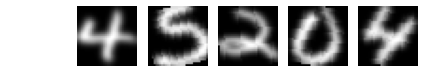

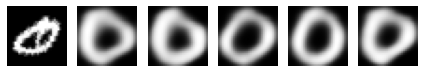

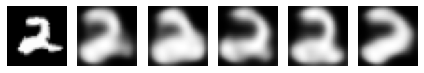

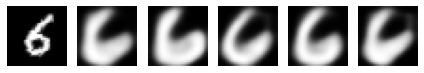

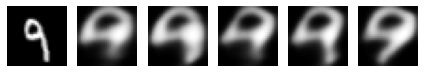

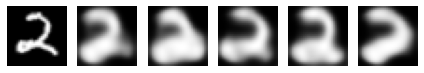

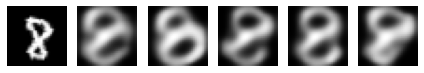

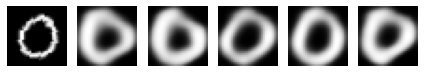

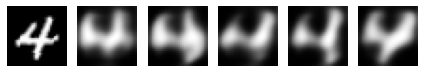

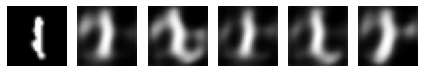

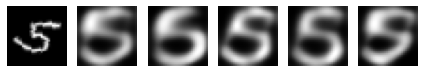

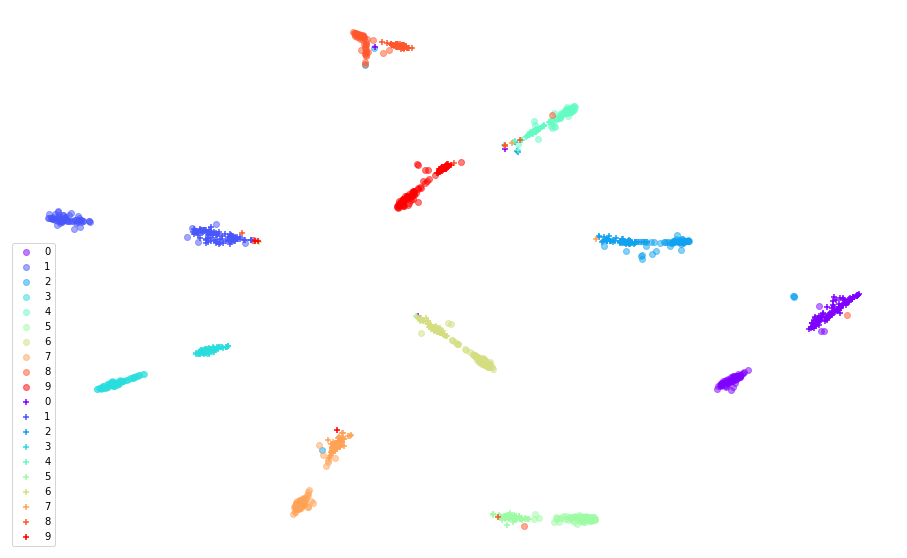

In [6]:
plot_target_cross_domain_swapping(model, source_train_loader, target_train_loader)
plot_tsne(model, source_train_loader, target_train_loader, batch_size=128, feature_size=150)